## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
import datetime as dt

## custome function

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray',colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap,colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fpath = "/content/drive/MyDrive/coding dojo/CodingDojo/05-IntermediateML/Week17/Data/car Insurance Dataset for project.csv"
df = pd.read_csv(fpath)
df=df.set_index('ID')
df.head()

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1,after 2015,0,1,10238,12000.0,sedan,0,0,0,0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0,before 2015,0,0,10238,16000.0,sedan,0,0,0,1
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1,before 2015,0,0,10238,11000.0,sedan,0,0,0,0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1,before 2015,0,1,32765,11000.0,sedan,0,0,0,0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1,before 2015,0,0,32765,12000.0,sedan,2,0,1,1


-What is the target?
* the traget is Outcome

-What does one row represent? (A person? A business? An event? A product?)
* The row represent a person

-How many features does the data have?
* The data have 6 Float features, 8 Object features and 5 integer features

-How many rows are in the dataset?
* the data have 10000 Rows


## Explore/clean the data


In [ ]:
df.duplicated().sum()

12

In [ ]:
df.isna().sum()

,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0
MARRIED,0


In [ ]:
data_types = df.dtypes
str_cols = data_types[data_types == 'object'].index
str_cols
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n")

- AGE:
AGE
26-39    3063
40-64    2931
16-25    2016
65+      1990
Name: count, dtype: int64


- GENDER:
GENDER
female    5010
male      4990
Name: count, dtype: int64


- RACE:
RACE
majority    9012
minority     988
Name: count, dtype: int64


- DRIVING_EXPERIENCE:
DRIVING_EXPERIENCE
0-9y      3530
10-19y    3299
20-29y    2119
30y+      1052
Name: count, dtype: int64


- EDUCATION:
EDUCATION
high school    4157
university     3928
none           1915
Name: count, dtype: int64


- INCOME:
INCOME
upper class      4336
middle class     2138
poverty          1814
working class    1712
Name: count, dtype: int64


- VEHICLE_YEAR:
VEHICLE_YEAR
before 2015    6967
after 2015     3033
Name: count, dtype: int64


- VEHICLE_TYPE:
VEHICLE_TYPE
sedan         9523
sports car     477
Name: count, dtype: int64




## Exploratory Visualizations

In [ ]:
# Final version of function
def plot_categorical_vs_target(df, x, y,figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [ ]:
def plot_numeric_vs_target(df, x, y, figsize=(6,4)):
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

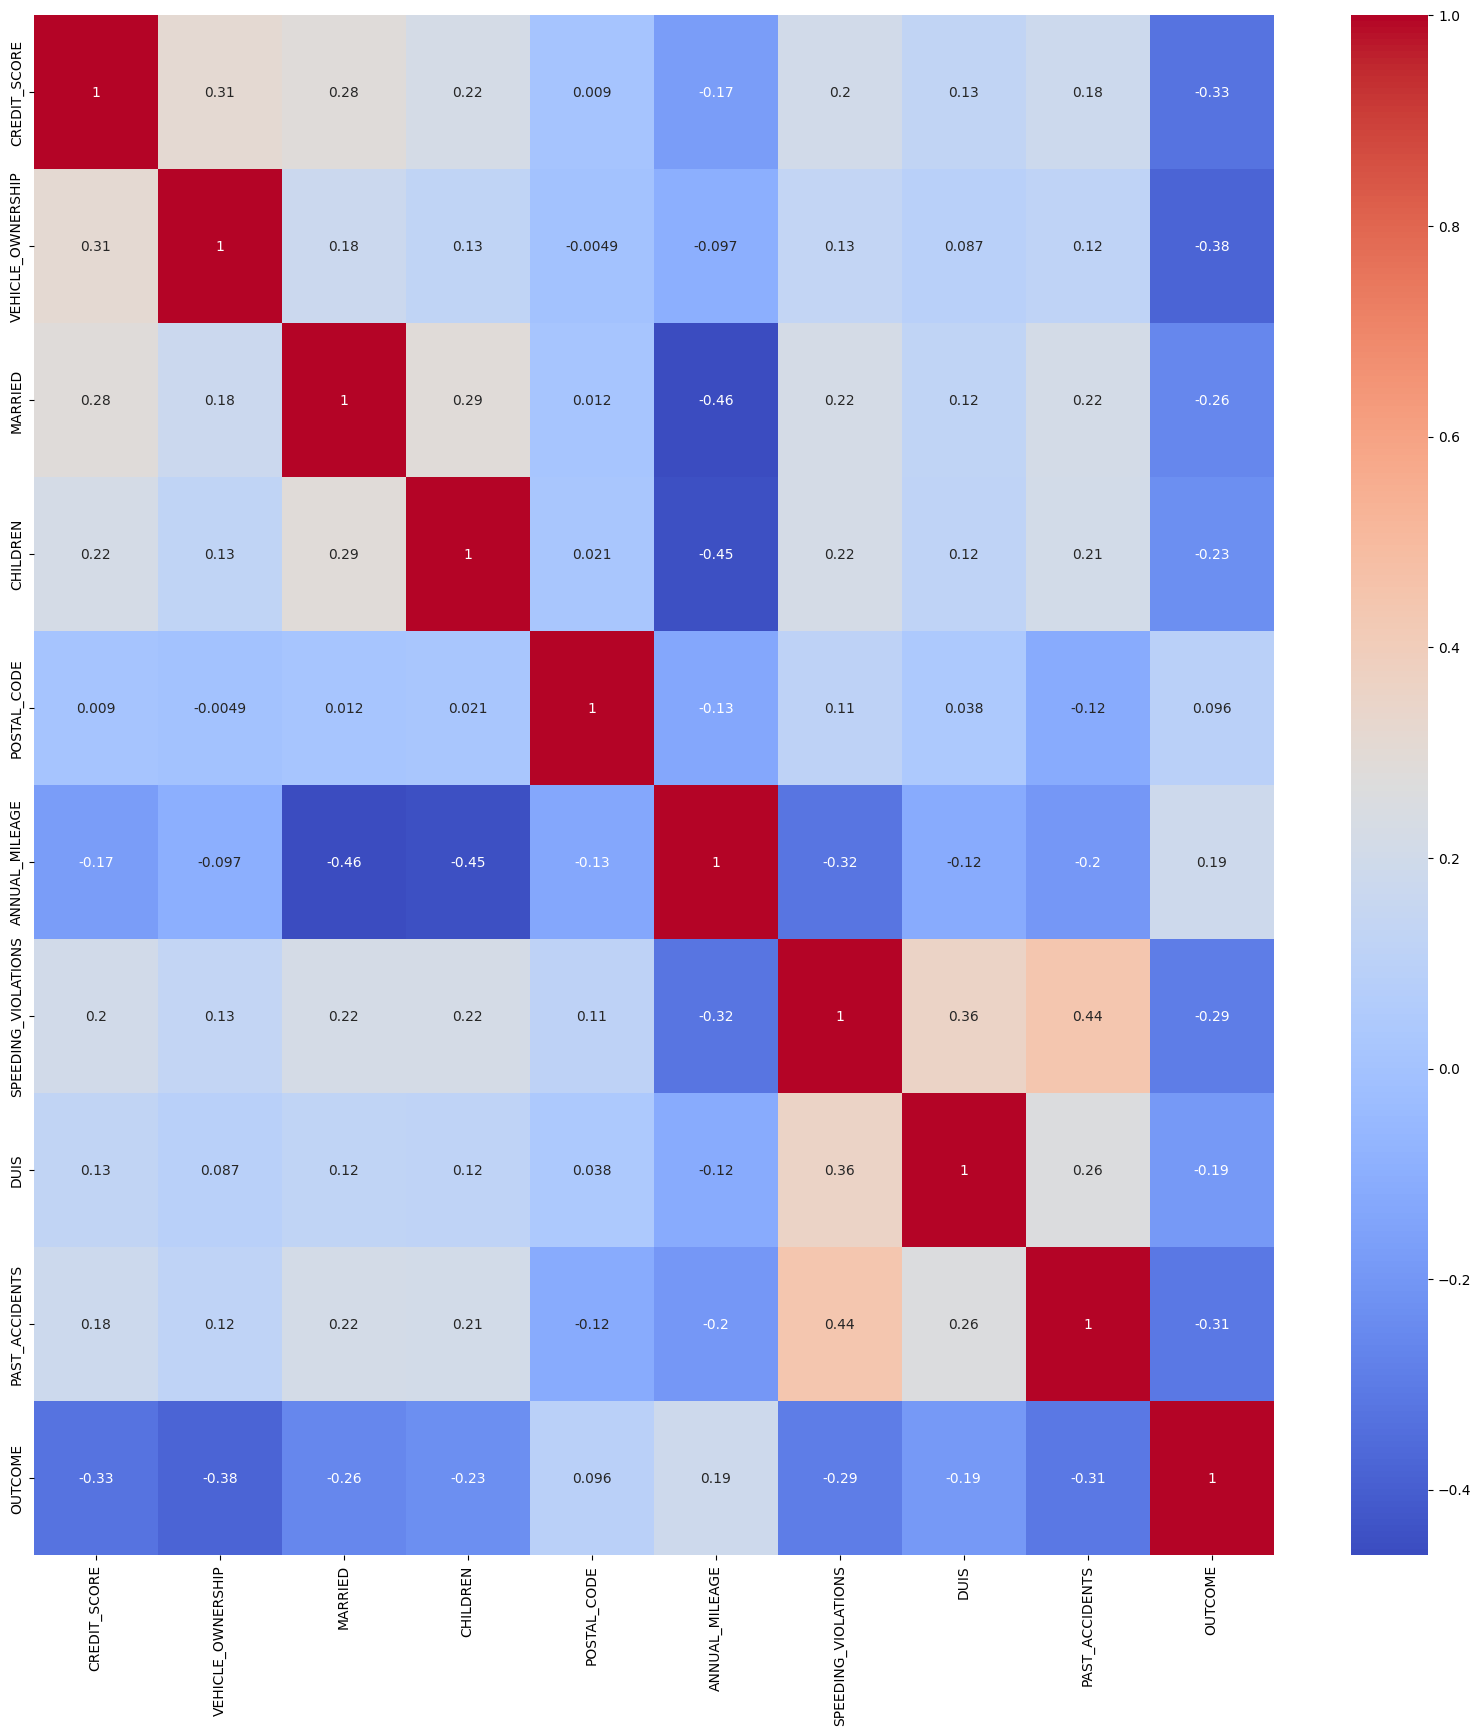

In [ ]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.show()

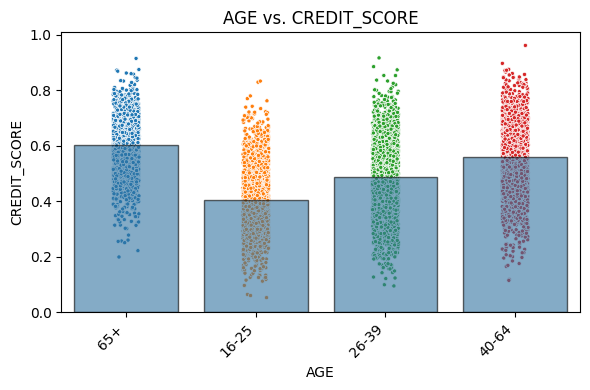

In [ ]:
fig, ax = plot_categorical_vs_target(df, x='AGE',y='CREDIT_SCORE')

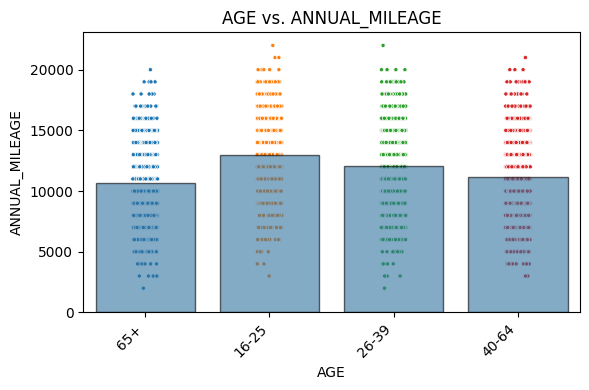

In [ ]:
fig, ax = plot_categorical_vs_target(df, x='AGE',y='ANNUAL_MILEAGE')

## Preprocess data


In [ ]:
X = df.drop(columns = ['OUTCOME']).copy()
y = df['OUTCOME'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 597605 to 480416
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  7500 non-null   object 
 1   GENDER               7500 non-null   object 
 2   RACE                 7500 non-null   object 
 3   DRIVING_EXPERIENCE   7500 non-null   object 
 4   EDUCATION            7500 non-null   object 
 5   INCOME               7500 non-null   object 
 6   CREDIT_SCORE         6755 non-null   float64
 7   VEHICLE_OWNERSHIP    7500 non-null   int64  
 8   VEHICLE_YEAR         7500 non-null   object 
 9   MARRIED              7500 non-null   int64  
 10  CHILDREN             7500 non-null   int64  
 11  POSTAL_CODE          7500 non-null   int64  
 12  ANNUAL_MILEAGE       6796 non-null   float64
 13  VEHICLE_TYPE         7500 non-null   object 
 14  SPEEDING_VIOLATIONS  7500 non-null   int64  
 15  DUIS                 7500 non-null  

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
ID,,,,,,,,,,,,,,,,,
597605,40-64,male,majority,0-9y,high school,upper class,0.694461,1,before 2015,1,1,92101,NaN,sedan,0,0,0
208394,16-25,female,majority,0-9y,none,poverty,0.295794,1,before 2015,0,0,32765,12000.0,sedan,0,0,0
318837,40-64,male,majority,10-19y,university,upper class,NaN,1,before 2015,1,1,10238,NaN,sedan,0,0,3
559214,26-39,female,majority,10-19y,university,working class,0.454836,1,before 2015,0,0,10238,20000.0,sedan,2,0,0
555274,16-25,female,majority,0-9y,none,poverty,0.152972,1,before 2015,1,0,10238,10000.0,sedan,0,0,0


In [ ]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('numeric', num_pipe, num_cols)

Numeric Columns: Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')


In [ ]:
ohe_cols =X_train.select_dtypes("object").columns


print("OneHotEncoder Columns:", ohe_cols)

impute_na = SimpleImputer(strategy='most_frequent')

ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)

OneHotEncoder Columns: Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object')


In [ ]:
preprocessor = ColumnTransformer([num_tuple, ohe_tuple], verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 Index(['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'VEHICLE_YEAR', 'VEHICLE_TYPE'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
X_train_tf = preprocessor.transform(X_train)

X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_26-39,AGE_40-64,AGE_65+,GENDER_male,RACE_minority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_none,EDUCATION_university,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car
ID,,,,,,,,,,,,,,,,,,,,,,,,
597605,1.367938,0.660062,1.000533,0.674880,3.867776,0.098334,-0.659296,-0.432581,-0.643278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
208394,-1.702804,0.660062,-0.999467,-1.481745,0.694321,0.098334,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
318837,0.063118,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,1.147363,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
559214,-0.477776,0.660062,-0.999467,-1.481745,-0.510486,3.099366,0.229004,-0.432581,-0.643278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
555274,-2.802891,0.660062,1.000533,-1.481745,-0.510486,-0.651924,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## Modeling: KNN Classification Model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5144
           1       0.79      0.76      0.78      2356

    accuracy                           0.86      7500
   macro avg       0.84      0.83      0.84      7500
weighted avg       0.86      0.86      0.86      7500



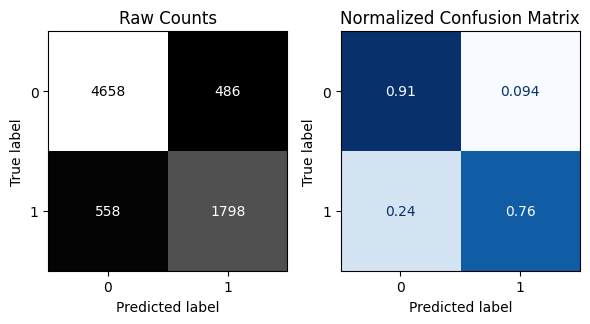


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1723
           1       0.71      0.69      0.70       777

    accuracy                           0.82      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.81      0.82      0.82      2500



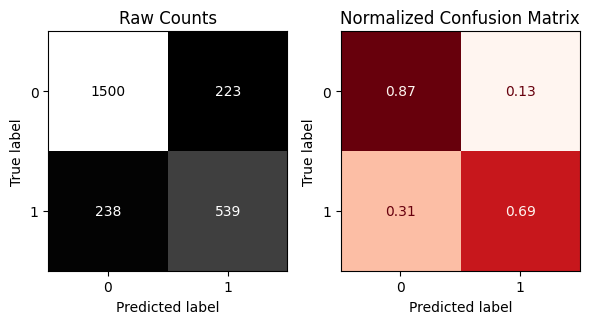

In [ ]:
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.fit(X_train, y_train)


evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

In [ ]:
y.value_counts()

,count
OUTCOME,
0,6867
1,3133


### Smote the data


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5144
           1       0.69      0.93      0.79      2356

    accuracy                           0.85      7500
   macro avg       0.83      0.87      0.84      7500
weighted avg       0.88      0.85      0.85      7500



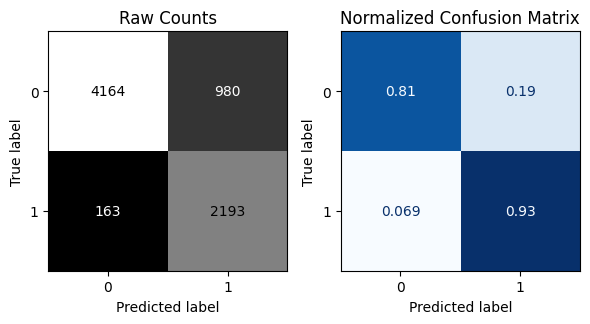


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1723
           1       0.60      0.82      0.69       777

    accuracy                           0.77      2500
   macro avg       0.75      0.79      0.75      2500
weighted avg       0.81      0.77      0.78      2500



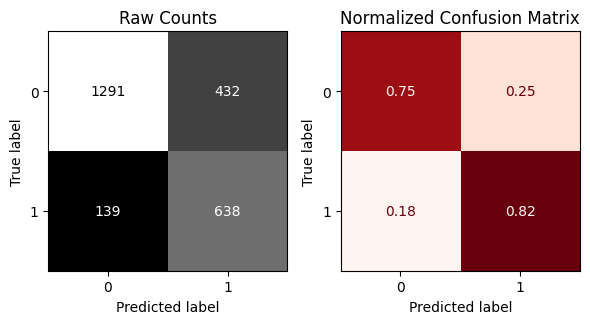

In [ ]:
smote = SMOTE(random_state=42)

knn_smote_pipe = make_sampler_pipeline(preprocessor, smote,  knn)

knn_smote_pipe.fit(X_train, y_train)

evaluate_classification(knn_smote_pipe, X_train, y_train, X_test, y_test)

* an increase in 1 Recall from 69% to 82%
* a decrease of the false positive from 31% to 18%

In [ ]:
knn_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
          'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
          'PAST_ACCIDENTS'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(drop='first',


## permutation importances


In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

In [ ]:
permutation_importances = permutation_importance(knn_smote_pipe , X_test, y_test, n_repeats=5, random_state=42)

In [ ]:
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test.columns,
                           name = 'permutation importance')

In [ ]:
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances

,permutation importance
DRIVING_EXPERIENCE,4.032000e-02
VEHICLE_OWNERSHIP,3.440000e-02
SPEEDING_VIOLATIONS,2.336000e-02
AGE,2.168000e-02
GENDER,1.800000e-02
VEHICLE_YEAR,1.768000e-02
DUIS,1.000000e-02
POSTAL_CODE,9.520000e-03
PAST_ACCIDENTS,7.840000e-03
EDUCATION,4.880000e-03


<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

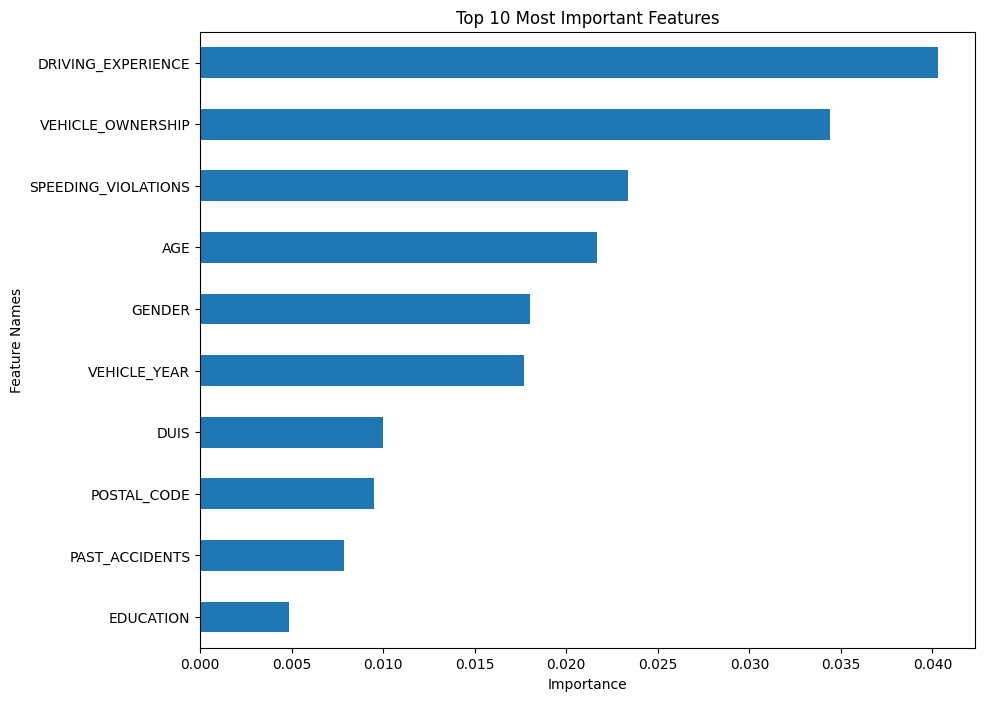

In [ ]:
n = 10
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))

## Visualizing important features


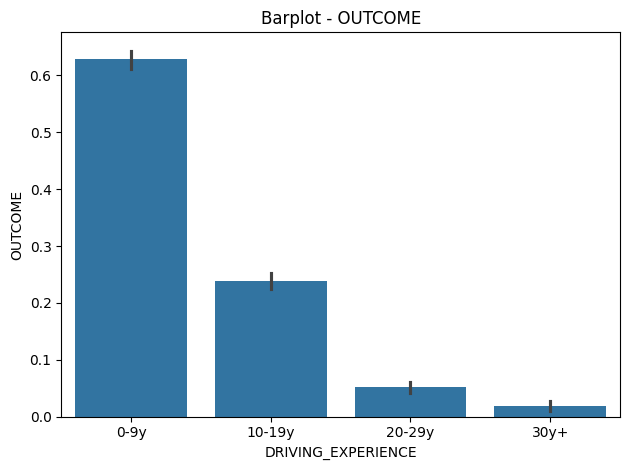

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.barplot(data=df, x='DRIVING_EXPERIENCE',y='OUTCOME');


plt.title("Barplot - OUTCOME")
plt.xlabel("DRIVING_EXPERIENCE")
plt.ylabel("OUTCOME")
plt.tight_layout();
plt.show();
plt.savefig('DEvsOUTCOME.png')

* The bar plot can show how different levels of driving experience (such as novice, intermediate, experienced) relate to the outcome of car insurance claims.

* It can help identify if certain levels of driving experience are more prone to accidents or have higher claim outcomes.

* Frequency of Claims Across Driving Experience Categories:

1. The height of the bars can indicate the frequency or count of claims associated with each level of driving experience.
2. You can observe if there are any significant differences in claim
frequency based on driving experience.




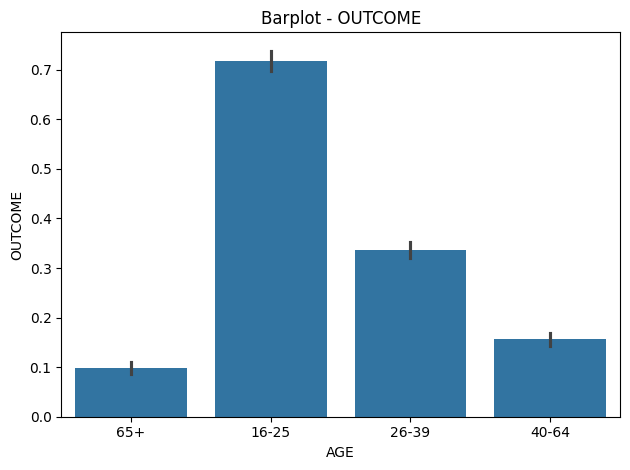

<Figure size 640x480 with 0 Axes>

In [ ]:
sns.barplot(data=df, x='AGE',y='OUTCOME');


plt.title("Barplot - OUTCOME")
plt.xlabel("AGE")
plt.ylabel("OUTCOME")
plt.tight_layout();
plt.show();
plt.savefig('AGEvsOUTCOME.png')

"Considering the distribution of results across different age groups, you can assess whether there are any patterns or trends based on age." Understanding how claims outcomes differ by age can be crucial for risk assessment and policy pricing.

## Choose two feature engineering


### 1. NonCollinear


In [ ]:
y_train.value_counts()

,count
OUTCOME,
0,5144
1,2356


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm,y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

,count
OUTCOME,
1,5144
0,5144


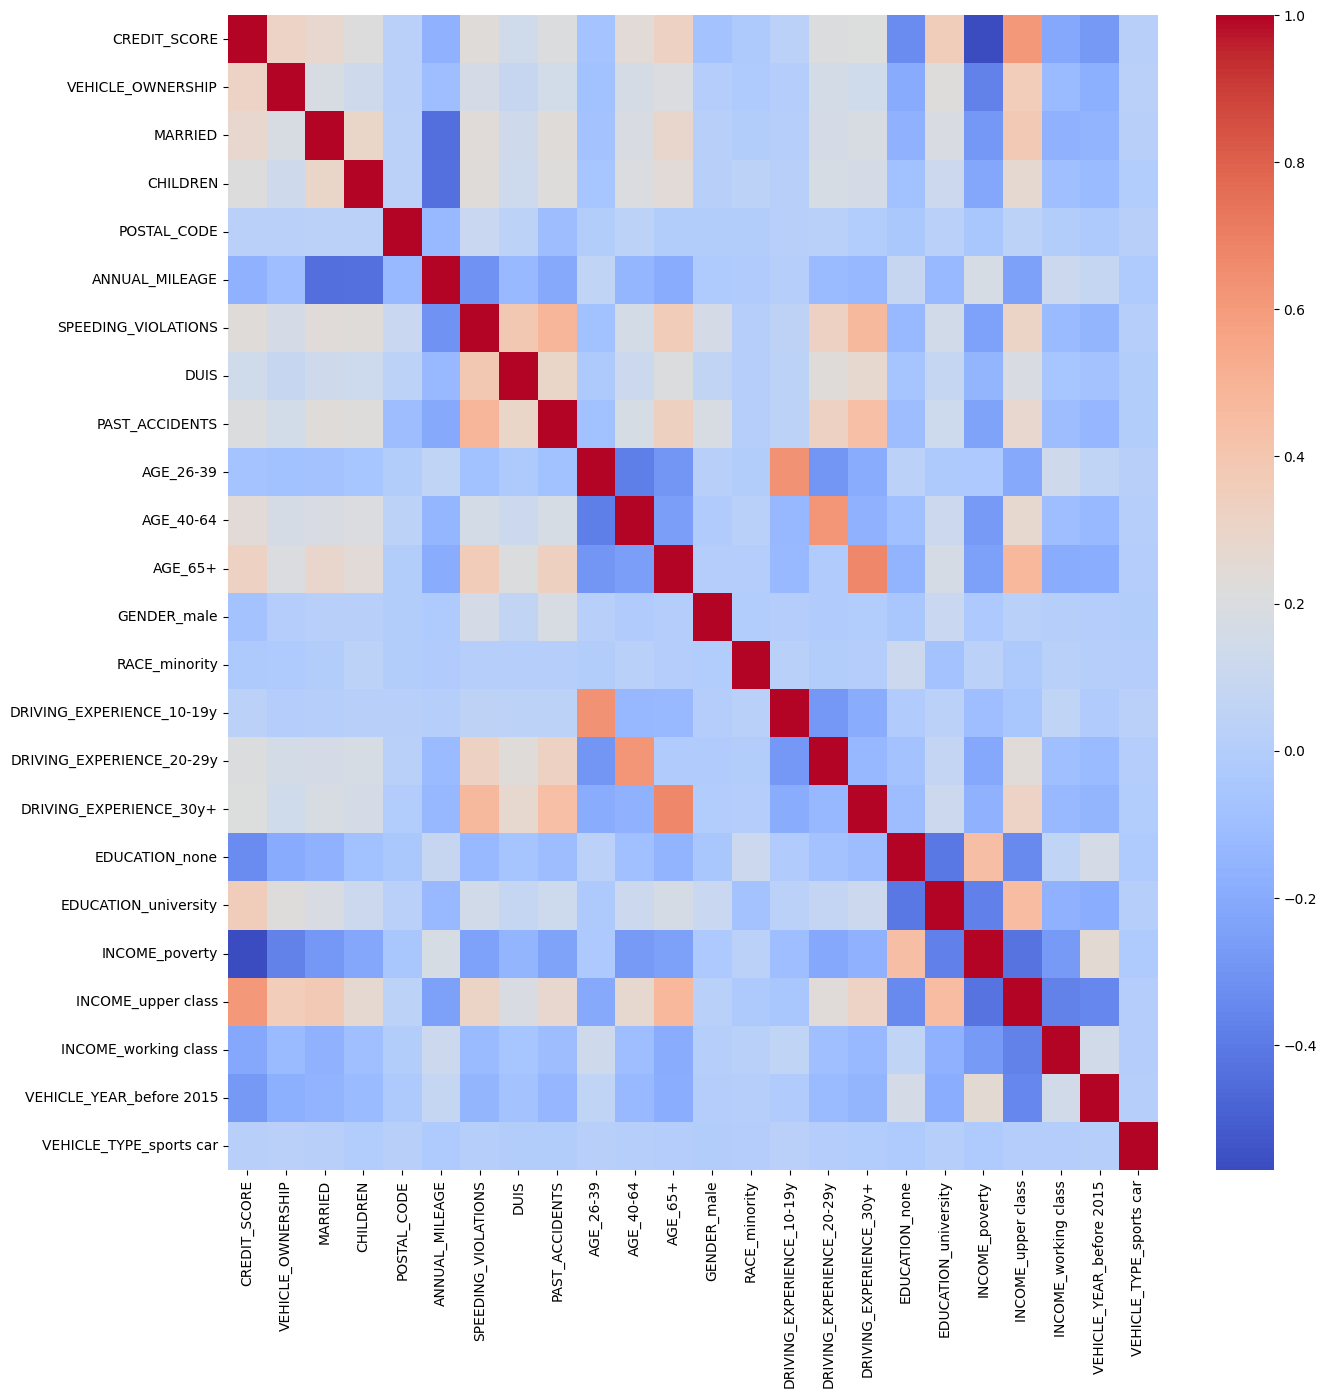

In [ ]:
# Make a correlation heatmap of all features
corr = X_train_sm.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

In [ ]:
!pip install collinearity
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

  Preparing metadata (setup.py) ... done
  Created wheel for collinearity: filename=collinearity-0.6.1-py3-none-any.whl size=4442 sha256=034ae5f8dfee4f8db0ac1a853a0f9deec2393fedcca84503f1628e9e0001b333
  Stored in directory: /root/.cache/pip/wheels/0e/b1/ea/957b5269b023343361d1f3182a3bd03f8a6fbc86ce713ce7cb
Successfully built collinearity


In [ ]:
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

In [ ]:
selector.fit(X_train_sm.values, y_train_sm.values)

In [ ]:
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, True]

In [ ]:
# Check how many features are below the theshold
non_collinear.count(True)

24

In [ ]:
# Check how many features are above the theshold
non_collinear.count(False)

0

In [ ]:
# Make the T/F a series with the column names as the index
non_collinear_series = pd.Series(selector.get_support(), index=X_train_sm.columns)
non_collinear_series

,0
CREDIT_SCORE,True
VEHICLE_OWNERSHIP,True
MARRIED,True
CHILDREN,True
POSTAL_CODE,True
ANNUAL_MILEAGE,True
SPEEDING_VIOLATIONS,True
DUIS,True
PAST_ACCIDENTS,True
AGE_26-39,True


In [ ]:
# Filter training data
training_data_to_keep = X_train_sm.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_sm.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5144
           1       0.84      0.96      0.90      5144

    accuracy                           0.89     10288
   macro avg       0.90      0.89      0.89     10288
weighted avg       0.90      0.89      0.89     10288



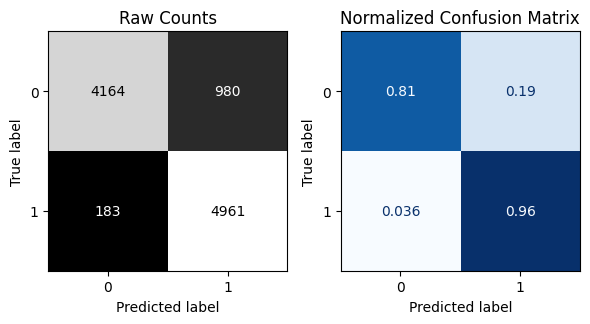


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1723
           1       0.60      0.82      0.69       777

    accuracy                           0.77      2500
   macro avg       0.75      0.79      0.75      2500
weighted avg       0.81      0.77      0.78      2500



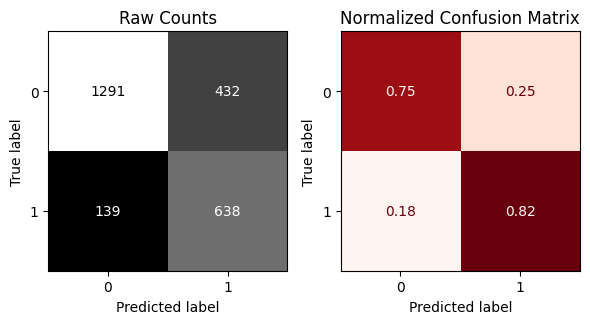

In [ ]:
# Test the performance
knn = KNeighborsClassifier()
knn.fit(X_train_no_corr, y_train_sm)
evaluate_classification(knn, X_train_no_corr, y_train_sm, X_test_no_corr, y_test)

### 2. Variance


In [ ]:
from sklearn.feature_selection import VarianceThreshold
# checking for constant-features
selector = VarianceThreshold(threshold=0.00)
selector.fit(X_train_tf)

VarianceThreshold()

In [ ]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]

array([ True,  True,  True,  True,  True])

In [ ]:
# Number of features to keep (non-constant features)
keep_features.sum()

24

In [ ]:
# checking for quasi-constant-features
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_tf)

VarianceThreshold(threshold=0.01)

In [ ]:
# get support returns true/false for keeping features
keep_features = selector.get_support()
keep_features[:5]


array([ True,  True,  True,  True,  True])

In [ ]:
# Number of features to keep (non-quasi-constant features)
keep_features.sum()

24

In [ ]:
# Filter based on variance
X_train_var = X_train_tf.loc[:,keep_features]
X_test_var = X_test_tf.loc[:,keep_features]
X_train_var

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_26-39,AGE_40-64,AGE_65+,GENDER_male,RACE_minority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_none,EDUCATION_university,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car
ID,,,,,,,,,,,,,,,,,,,,,,,,
597605,1.367938,0.660062,1.000533,0.674880,3.867776,0.098334,-0.659296,-0.432581,-0.643278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
208394,-1.702804,0.660062,-0.999467,-1.481745,0.694321,0.098334,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
318837,0.063118,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,1.147363,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
559214,-0.477776,0.660062,-0.999467,-1.481745,-0.510486,3.099366,0.229004,-0.432581,-0.643278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
555274,-2.802891,0.660062,1.000533,-1.481745,-0.510486,-0.651924,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897410,1.359188,0.660062,1.000533,0.674880,-0.510486,0.848592,0.673153,1.348077,1.147363,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
674120,0.039220,0.660062,-0.999467,-1.481745,-0.510486,-0.276795,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
295737,0.840692,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,0.550483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
# Use standardscaler to Scale
scaler = StandardScaler()
scaler.fit(X_train_var)
X_train_var_scaled = scaler.transform(X_train_var)
X_test_var_scaled = standard=scaler.transform(X_test_var)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_var_scaled_sm, y_train_sm = smote.fit_resample(X_train_var_scaled, y_train)
y_train_sm.value_counts()

,count
OUTCOME,
1,5144
0,5144


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      5144
           1       0.85      0.96      0.90      5144

    accuracy                           0.90     10288
   macro avg       0.90      0.90      0.90     10288
weighted avg       0.90      0.90      0.90     10288



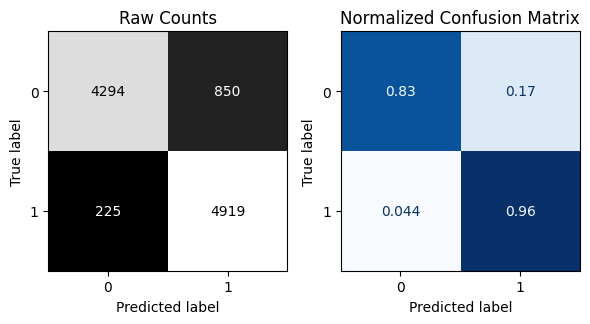


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1723
           1       0.61      0.78      0.69       777

    accuracy                           0.78      2500
   macro avg       0.75      0.78      0.76      2500
weighted avg       0.80      0.78      0.78      2500



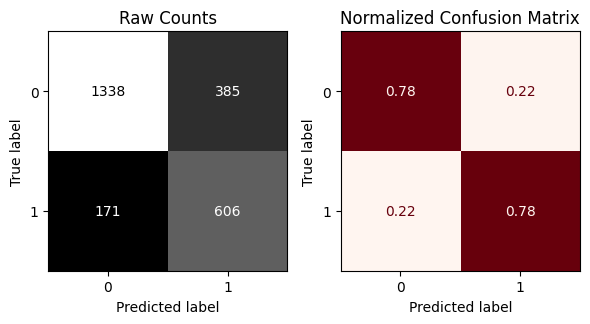

In [ ]:
# Test the performance
knn = KNeighborsClassifier()
knn.fit(X_train_var_scaled_sm, y_train_sm)
evaluate_classification(knn, X_train_var_scaled_sm, y_train_sm, X_test_var_scaled, y_test)

## PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Inertia

In [ ]:
X_train_no_corr.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,AGE_26-39,AGE_40-64,AGE_65+,GENDER_male,RACE_minority,DRIVING_EXPERIENCE_10-19y,DRIVING_EXPERIENCE_20-29y,DRIVING_EXPERIENCE_30y+,EDUCATION_none,EDUCATION_university,INCOME_poverty,INCOME_upper class,INCOME_working class,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car
0,1.367938,0.660062,1.000533,0.674880,3.867776,0.098334,-0.659296,-0.432581,-0.643278,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-1.702804,0.660062,-0.999467,-1.481745,0.694321,0.098334,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.063118,0.660062,1.000533,0.674880,-0.510486,0.098334,-0.659296,-0.432581,1.147363,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.477776,0.660062,-0.999467,-1.481745,-0.510486,3.099366,0.229004,-0.432581,-0.643278,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,-2.802891,0.660062,1.000533,-1.481745,-0.510486,-0.651924,-0.659296,-0.432581,-0.643278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_no_corr)
X_test_pca = pca.transform(X_test_no_corr)

pca.explained_variance_ratio_.sum()

0.9521356296355622

Text(0, 0.5, 'inertia')

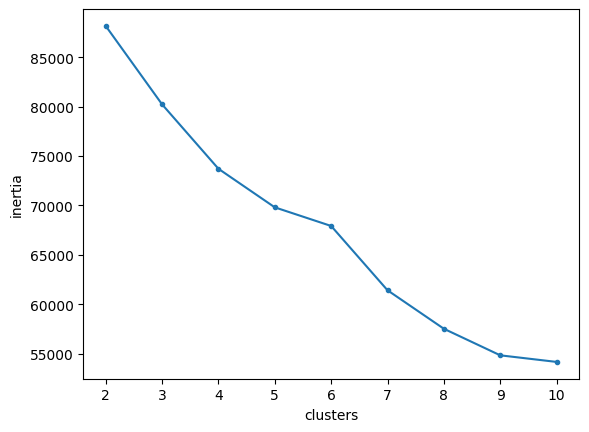

In [ ]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, n_init = 'auto', random_state = 42)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia')

## Silhouette Score for KMeans


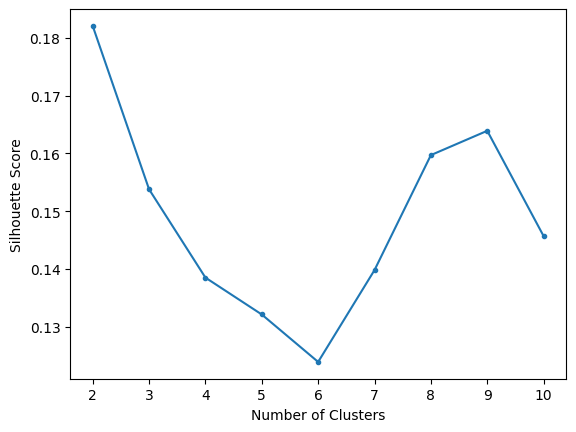

In [ ]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = 42)
  kmeans.fit(X_train_pca)
  silhouette_scores.append(silhouette_score(X_train_pca, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

In [ ]:
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 2, n_init = 'auto', random_state = 42)
kmeans.fit(X_train_pca)
silhouette_score(X_train_pca, kmeans.labels_)
X_train_pca['cluster'] = kmeans.labels_
X_train_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,cluster
0,1.481388,-0.335108,-3.596457,1.610026,0.550317,-0.414846,-0.106700,-1.305047,-0.415242,-0.351377,0.176838,-0.165335,-0.941227,-0.273829,-0.177750,0
1,-1.889917,0.039210,-0.593615,0.797665,-1.231671,1.192944,-0.103691,0.484650,-0.608517,-0.275818,0.223459,0.725666,0.209176,-0.317068,-0.104469,1
2,1.373748,0.558820,0.116934,-1.059270,-0.224131,0.324055,-0.436714,-1.095780,0.253107,-0.788453,-0.279051,-0.698755,0.148301,-0.431357,-0.438395,0
3,-2.086468,2.454659,0.462469,0.848335,-0.253760,0.018434,-0.040433,-0.819204,1.173781,1.117298,0.287731,-0.373099,0.725398,0.643665,-0.385731,1
4,-1.339380,-0.713595,0.013114,-0.646722,-1.210074,3.023480,0.364734,0.115553,-0.557602,0.023543,0.154917,0.566023,0.433120,-0.235990,-0.052332,1


### Use PCA to define two principal components


In [ ]:
pca = PCA()
df_pca = pca.fit_transform(X_train_pca)

In [ ]:
print(df_pca.columns)

Index(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15'],
      dtype='object')


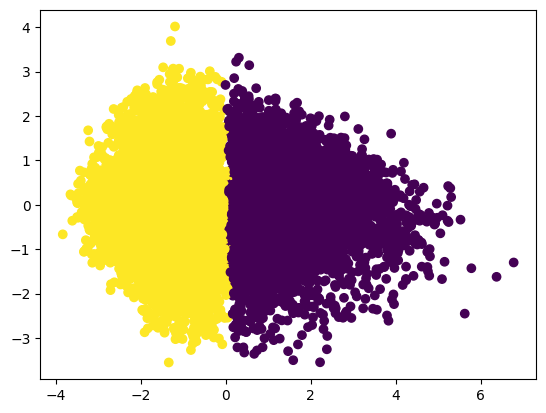

In [ ]:
plt.scatter(df_pca['pca0'], df_pca['pca1'], c=kmeans.labels_)

### Fit and evaluate a model using new features and compare it to your model from Part 1.


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Instantiate the model
dt = DecisionTreeClassifier(random_state = 42)

In [ ]:
# Instantiate the SequentialFeatureSelector
sk_sfs = SequentialFeatureSelector(dt, n_features_to_select=15,
                                direction = 'forward', cv=2,
                                 n_jobs=-1)
sk_sfs.fit(X_train_no_corr,y_train_sm)

SequentialFeatureSelector(cv=2,
                          estimator=DecisionTreeClassifier(random_state=42),
                          n_features_to_select=15, n_jobs=-1)

In [ ]:
# Preview array of T/F for selected (or not) features
sk_sfs.support_[0:5]

array([False,  True,  True,  True,  True])

In [ ]:
# .support_ returns an array of T/F whether it is above threshold
features_to_keep = sk_sfs.support_
# Only include the features selected
X_train_15 = X_train_no_corr.loc[:,features_to_keep]
X_test_15 = X_test_no_corr.loc[:,features_to_keep]
X_train_15.shape

(10288, 15)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      5144
           1       0.86      0.88      0.87      5144

    accuracy                           0.87     10288
   macro avg       0.87      0.87      0.87     10288
weighted avg       0.87      0.87      0.87     10288



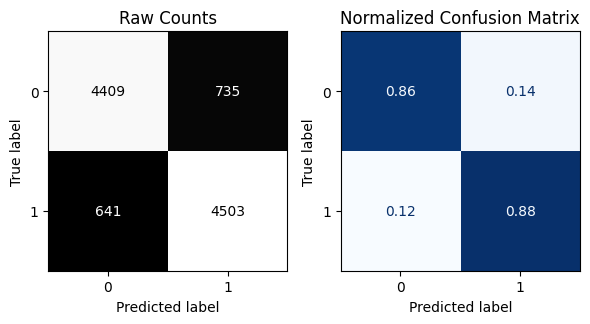


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1723
           1       0.64      0.75      0.69       777

    accuracy                           0.79      2500
   macro avg       0.76      0.78      0.77      2500
weighted avg       0.80      0.79      0.80      2500



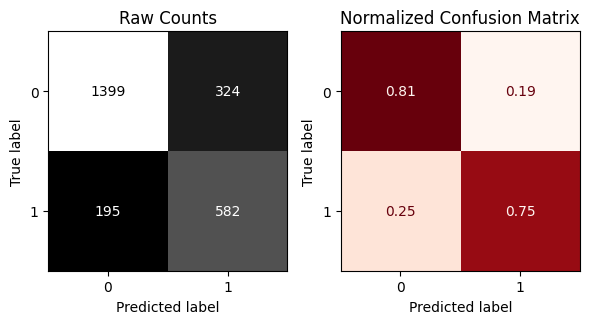

In [ ]:
# Instantiate default random forest
knn = KNeighborsClassifier()
# Fit on 15 selected featuers
knn.fit(X_train_15, y_train_sm)
# Evaluate with custom function
evaluate_classification(knn, X_train_15, y_train_sm, X_test_15, y_test)

## New permutation importances


<Axes: title={'center': 'Top 10 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

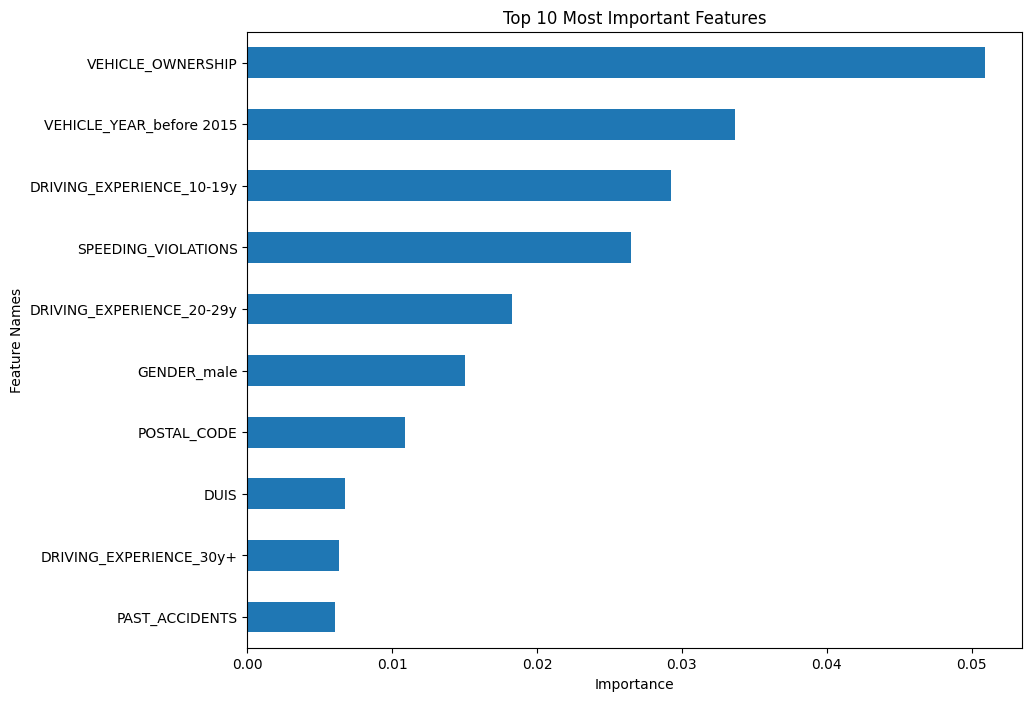

In [ ]:
permutation_importances = permutation_importance(knn , X_test_15, y_test, n_repeats=5, random_state=42)
permutation_importances = pd.Series(permutation_importances['importances_mean'],index=X_test_15.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)

permutation_importances
n = 10
plot_importance_color_ax(permutation_importances, top_n=n,
                         figsize=(10,8))

## Deep Learning


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout


# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline

# import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train_enc = label_encoder.fit_transform(y_train_sm)
y_test_enc = label_encoder.fit_transform(y_test)

classes = label_encoder.classes_

print('\nEncoded Target')
print(y_train_enc[:5])


Encoded Target
[1 0 0 1 0]


## Model 1


In [ ]:
# Define input shape
input_shape = X_train_no_corr.shape[1]
input_shape

24

In [ ]:
def build_model():

    model = Sequential()

    # First hidden layer
    model.add(Dense(24,
                    input_dim = input_shape,
                    activation = 'relu'))

    model.add(Dense(12,
                activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))



    model.compile(loss = 'bce', optimizer = 'adam',
              metrics=['accuracy',
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision'),
                        ])

    return model

In [ ]:
# Call our build function to build model
binary_model = build_model()

# Get model summary
binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 24)                  │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 913 (3.57 KB)

 Trainable params: 913 (3.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
X_train_no_corr.shape

(10288, 24)

In [ ]:
y_train_enc.shape

(10288,)

In [ ]:
history = binary_model.fit(X_train_no_corr, y_train_enc,
                      validation_split=0.2,
                      epochs=50,
                      verbose=1,
                      callbacks=[early_stopping])

Epoch 1/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6985 - loss: 0.5673 - precision: 0.6739 - recall: 0.3428 - val_accuracy: 0.7643 - val_loss: 0.5366 - val_precision: 1.0000 - val_recall: 0.7643
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8169 - loss: 0.4076 - precision: 0.7607 - recall: 0.7438 - val_accuracy: 0.8120 - val_loss: 0.4515 - val_precision: 1.0000 - val_recall: 0.8120
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8274 - loss: 0.3771 - precision: 0.7764 - recall: 0.7618 - val_accuracy: 0.8236 - val_loss: 0.4258 - val_precision: 1.0000 - val_recall: 0.8236
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8385 - loss: 0.3693 - precision: 0.7900 - recall: 0.7765 - val_accuracy: 0.8124 - val_loss: 0.4486 - val_precision: 1.0000 - val_recall: 0.8124
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8502 - loss: 0.3536 - precision: 0.8038 - recall: 0.7935 - val_accuracy: 0.8649 - val_loss: 0.

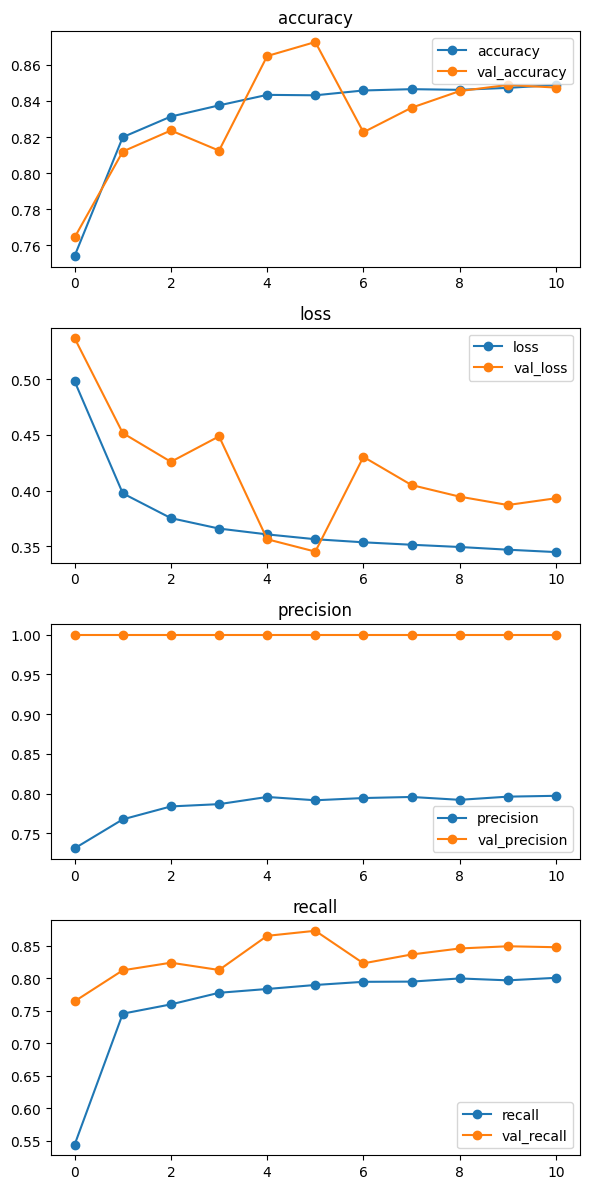

In [ ]:
# plot learning
plot_history(history);

In [ ]:
# make predictions
y_pred_train = binary_model.predict(X_train_no_corr)


# round the predictions
y_pred_train = np.round(y_pred_train)


y_pred_test = binary_model.predict(X_test_no_corr)


# round the predictions
y_pred_test = np.round(y_pred_test)

322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
def model_6(model_1, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test):
    # make predictions

    print('-' * 60)
    print('Train data')
    print('-' * 60)
    print(classification_report(y_train_enc, y_pred_train))

    print('-' * 60)
    print('Test data')
    print('-' * 60)
    print(classification_report(y_test_enc, y_pred_test))

    RR = ConfusionMatrixDisplay.from_predictions(y_train_enc, y_pred_train, cmap='Blues',
                                                  normalize='true').ax_.set_title('training data')
    RRR = ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_test, cmap='Greens',
                                                  normalize='true').ax_.set_title('test data')

------------------------------------------------------------
Train data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      5144
           1       0.87      0.82      0.85      5144

    accuracy                           0.85     10288
   macro avg       0.85      0.85      0.85     10288
weighted avg       0.85      0.85      0.85     10288

------------------------------------------------------------
Test data
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1723
           1       0.73      0.76      0.74       777

    accuracy                           0.84      2500
   macro avg       0.81      0.82      0.81      2500
weighted avg       0.84      0.84      0.84      2500



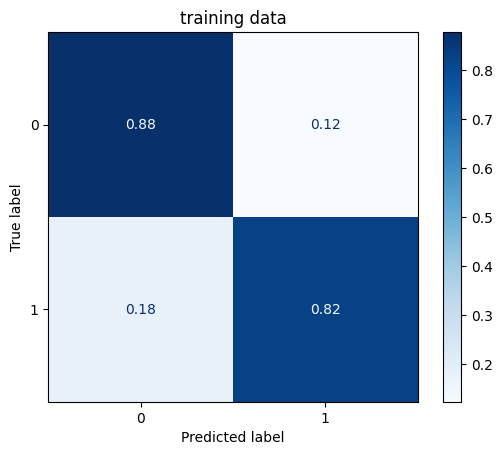

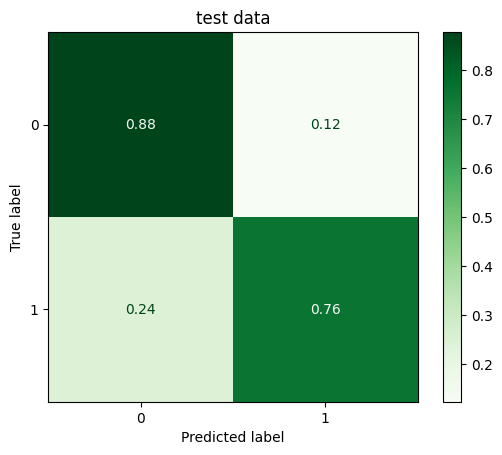

In [ ]:
model_6(binary_model, X_test_no_corr, y_train_enc, y_pred_train, y_test_enc, y_pred_test)

### Tunning Model 1


In [ ]:
!pip install keras-tuner
from keras_tuner import HyperParameters as hp
import keras_tuner as kt


def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # First hidden layer
    model.add(Dense(19, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?


    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=50, step=5), activation='relu'))



    # Try different values for dropout rate
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))




    model.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    # Try different optimizers
    model.compile(optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
                  loss='bce',
                  metrics=['accuracy',
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision')])
    return model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
# Mount Google Drive
drive.mount('/content/drive')

# Define the directory path within Google Drive
folder = '/content/drive/My Drive/KerasTuner'

# Create the directory if it doesn't exist
os.makedirs(folder, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='Rookie_tuning')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history_2 = tuner.search(X_train_no_corr, y_train_enc,  epochs=50,
              validation_split = .2, callbacks = [early_stop])

Trial 172 Complete [00h 00m 10s]
val_accuracy: 0.8445092439651489

Best val_accuracy So Far: 0.9071914553642273
Total elapsed time: 00h 22m 59s


In [ ]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 35,
 'dropout_value': 0.0,
 'optimizer': 'adam',
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0128'}

In [ ]:
# Obtain best model
search_binary_model = tuner.get_best_models()[0]
search_binary_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 19)                  │             475 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 35)                  │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 35)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,211 (4.73 KB)

 Trainable params: 1,211 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Evaluate neural network with built in evaluation
result_tuner = search_binary_model.evaluate(X_test_no_corr, y_test_enc, return_dict=True)
result_tuner

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8365 - loss: 0.3776 - precision: 0.7151 - recall: 0.8324


{'accuracy': 0.8312000036239624,
 'loss': 0.38108307123184204,
 'precision': 0.6886290907859802,
 'recall': 0.8339768052101135}

In [ ]:
# make predictions
y_pred_train_tuner = search_binary_model.predict(X_train_no_corr)


# round the predictions
y_pred_train_tuner = np.round(y_pred_train_tuner)

322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
# make predictions
y_pred_test_tuner = search_binary_model.predict(X_test_no_corr)


# round the predictions
y_pred_test_tuner = np.round(y_pred_test_tuner)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
def model_2(y_train_enc, y_pred_train_tuner, y_test_enc, y_pred_test_tuner):
    print('-' * 60)
    print('Train data')
    print('-' * 60)
    print(classification_report(y_train_enc, y_pred_train_tuner))

    print('-' * 60)
    print('Test data')
    print('-' * 60)
    print(classification_report(y_test_enc, y_pred_test_tuner))

    RR_tuner = ConfusionMatrixDisplay.from_predictions(y_train_enc, y_pred_train_tuner, cmap='Blues',
                                                       normalize='true').ax_.set_title('training data')
    RRR_tuner = ConfusionMatrixDisplay.from_predictions(y_test_enc, y_pred_test_tuner, cmap='Greens',
                                                        normalize='true').ax_.set_title('test data')
